In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [45]:
np.random.seed(4)

In [46]:
file_path = "../data/AirlineTweets.csv"
df = pd.read_csv(file_path)

In [47]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [48]:
df = df[['airline_sentiment', 'text']]

<AxesSubplot: >

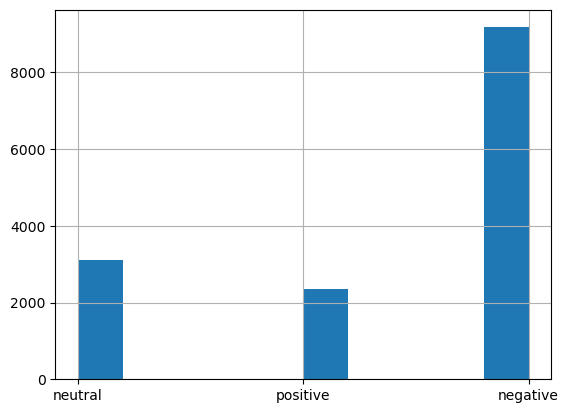

In [49]:
df["airline_sentiment"].hist()

In [50]:
df = df[df["airline_sentiment"] != "neutral"].copy()

In [51]:
target_map = {"negative": 0, "positive": 1}
df["target"] = df["airline_sentiment"].map(target_map)

In [52]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [53]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=4)

In [54]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train["text"])
X_test = vectorizer.transform(df_test["text"])

In [55]:
#data shouldnt be a sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [56]:
Y_train = df_train["target"]
Y_test = df_test["target"]

In [57]:
#input dimensions
D = X_train.shape[1]

In [58]:
#build the model
i = Input(shape=(D,))
x =  Dense(1)(i) #sigmoid included in loss function

model = Model(i, x)

In [59]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"],   
)

In [61]:
r = model.fit(
    X_train, Y_train,   
    validation_data=(X_test, Y_test),
    epochs=40,
    batch_size=128)

Epoch 1/40
73/73 [==============================] - 3s 7ms/step - loss: 0.4935 - accuracy: 0.7943 - val_loss: 0.4002 - val_accuracy: 0.7990
Epoch 2/40
73/73 [==============================] - 0s 5ms/step - loss: 0.3676 - accuracy: 0.7999 - val_loss: 0.3419 - val_accuracy: 0.8168
Epoch 3/40
73/73 [==============================] - 0s 5ms/step - loss: 0.3139 - accuracy: 0.8252 - val_loss: 0.3044 - val_accuracy: 0.8419
Epoch 4/40
73/73 [==============================] - 0s 6ms/step - loss: 0.2769 - accuracy: 0.8515 - val_loss: 0.2788 - val_accuracy: 0.8575
Epoch 5/40
73/73 [==============================] - 0s 5ms/step - loss: 0.2500 - accuracy: 0.8687 - val_loss: 0.2607 - val_accuracy: 0.8766
Epoch 6/40
73/73 [==============================] - 0s 5ms/step - loss: 0.2298 - accuracy: 0.8855 - val_loss: 0.2473 - val_accuracy: 0.8878
Epoch 7/40
73/73 [==============================] - 0s 5ms/step - loss: 0.2136 - accuracy: 0.8988 - val_loss: 0.2370 - val_accuracy: 0.8969
Epoch 8/40
73/73 [==

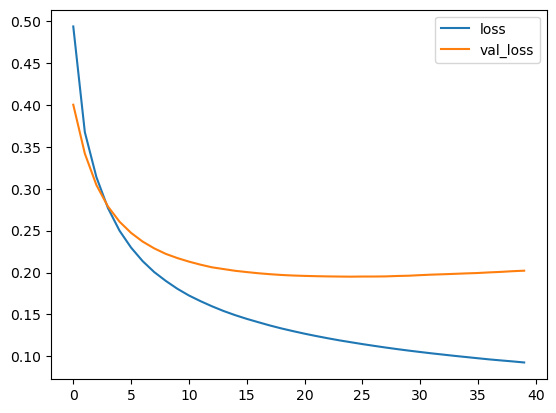

In [62]:
#Plot loss per iteration
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

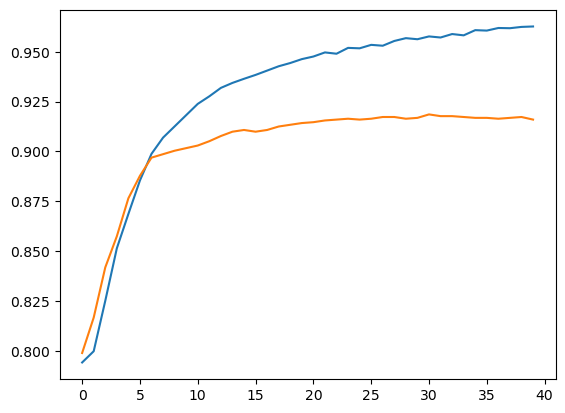

In [63]:
#Plot accuracy per iteration
plt.plot(r.history["accuracy"], label="acc")
plt.plot(r.history["val_accuracy"], label="val_acc")

In [78]:
p_train = ((model.predict(X_train) > 0) * 1.0).flatten()
p_test = ((model.predict(X_test) > 0) * 1.0).flatten()

73/73 [==============================] - 0s 1ms/step


In [82]:
cm = confusion_matrix(Y_train, p_train)
cm

array([[7254,   79],
       [ 173, 1726]], dtype=int64)

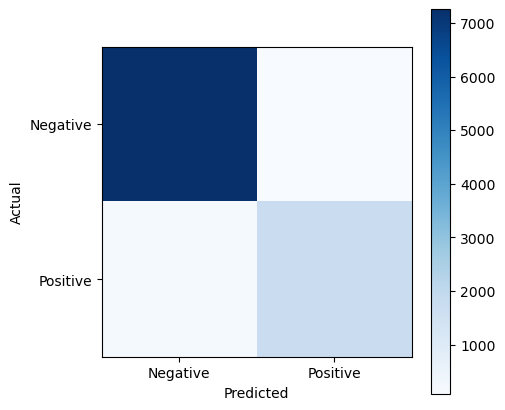

In [83]:
#plot confusion matrix
def plot_cm(cm):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, cmap="Blues", interpolation="nearest")
    plt.xticks([0,1], ["Negative", "Positive"])
    plt.yticks([0,1], ["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    plt.show()
#for train set
plot_cm(cm)


In [84]:
cm_test = confusion_matrix(Y_test, p_test, normalize="true")
cm_test
    

array([[0.96260163, 0.03739837],
       [0.24568966, 0.75431034]])

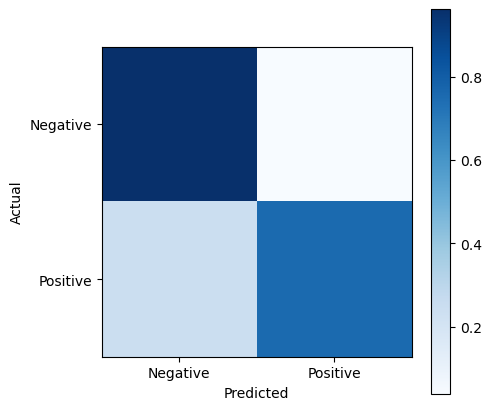

In [85]:
plot_cm(cm_test)

In [86]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print("Train ROC-AUC:", roc_auc_score(Y_train, pred_train))
print("Test ROC-AUC:", roc_auc_score(Y_test, pred_test))


73/73 [==============================] - 0s 1ms/step
Train ROC-AUC: 0.9948265636374252
Test ROC-AUC: 0.9553727455378002


In [87]:
print("Train F1:", f1_score(Y_train, p_train))
print("Test F1:", f1_score(Y_test, p_test))

Train F1: 0.9319654427645788
Test F1: 0.7927519818799547


In [88]:
model.layers

In [89]:
model.layers[1].get_weights()

[array([[-3.8022773 ],
        [ 1.9531124 ],
        [-3.5021298 ],
        ...,
        [ 0.7996772 ],
        [ 0.07087082],
        [-2.313924  ]], dtype=float32),
 array([-0.23836938], dtype=float32)]

In [90]:
w = model.layers[1].get_weights()[0]

In [92]:
word_index = vectorizer.vocabulary_
word_index 

{'usairways': 1870,
 'americanair': 136,
 'love': 1077,
 'you': 1995,
 'guys': 824,
 'amp': 139,
 'gonna': 812,
 'let': 1032,
 'finish': 711,
 'but': 287,
 've': 1883,
 'been': 232,
 'on': 1253,
 'hold': 881,
 'for': 751,
 'hour': 898,
 'trying': 1817,
 'to': 1777,
 'book': 260,
 'flight': 723,
 'my': 1189,
 'voucher': 1892,
 'united': 1850,
 'sent': 1559,
 'dm': 553,
 'with': 1950,
 'file': 701,
 'number': 1230,
 'just': 985,
 'want': 1900,
 'know': 997,
 'if': 922,
 'someone': 1626,
 'has': 846,
 'located': 1058,
 'bag': 215,
 'even': 626,
 'it': 967,
 'not': 1219,
 'here': 871,
 'yet': 1992,
 'southwestair': 1639,
 'sure': 1697,
 'can': 300,
 'trust': 1815,
 'that': 1741,
 'many': 1106,
 'small': 1612,
 'numbers': 1231,
 'above': 72,
 'words': 1960,
 'http': 907,
 'co': 376,
 'thanks': 1739,
 'your': 1996,
 'attention': 194,
 'flying': 745,
 'southwest': 1638,
 'years': 1987,
 'and': 141,
 'haven': 851,
 'had': 826,
 'this': 1755,
 'issue': 964,
 'in': 933,
 'the': 1743,
 'past': 13

In [93]:
#Check the weights of the words
threshold = 0.5

print("Most positive words:")
word_weights = [(w[i], word) for word, i in word_index.items()]
word_weights.sort(reverse=True)
for weight, word in word_weights[:10]:
    if weight > threshold:
        print(word, weight)

Most positive words:
thanks [9.852122]
thank [9.701515]
great [8.456082]
amazing [7.7959814]
excellent [7.192834]
love [7.0221086]
kudos [6.907403]
awesome [6.8786836]
worries [6.3809104]
wonderful [6.1904697]


In [94]:
print("Most negative words:")
word_weights = [(w[i], word) for word, i in word_index.items()]
word_weights.sort()
for weight, word in word_weights[:10]:
    if weight < -threshold:
        print(word, weight) 
            

Most negative words:
worst [-9.625846]
rude [-8.344535]
luggage [-7.5515213]
paid [-7.4458766]
disappointed [-7.3938856]
not [-7.117373]
money [-6.9450083]
hours [-6.704865]
fail [-6.566848]
delayed [-6.5071306]


In [95]:
#todo: spam detection